Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

In [45]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Ridge Regression

For this project, you'll return to the Tribecca Condo dataset. But this time, you'll look at the _entire_ dataset and try to predict property sale prices.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.

## Directions

The tasks for this project are the following:

- **Task 1:** Import `csv` file using `wrangle` function.
- **Task 2:** Conduct exploratory data analysis (EDA), and modify `wrangle` function to engineer two subset your dataset to one-family dwellings whose price is between \\$100,000 and \\$2,000,000.
- **Task 3:** Split data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and test sets.
- **Task 5:** Establish the baseline mean absolute error for your dataset.
- **Task 6:** Build and train a `OneHotEncoder`, and transform `X_train` and `X_test`.
- **Task 7:** Build and train a `LinearRegression` model.
- **Task 8:** Build and train a `Ridge` model.
- **Task 9:** Calculate the training and test mean absolute error for your `LinearRegression` model.
- **Task 10:** Calculate the training and test mean absolute error for your `Ridge` model.
- **Task 11:** Create a horizontal bar chart showing the 10 most influencial features for your `Ridge` model. 

**Note**

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `sklearn`

# I. Wrangle Data

In [46]:
import pandas as pd
from category_encoders import OneHotEncoder

In [47]:
def wrangle(filepath):
    # Import csv file
    cols = ['BOROUGH', 'NEIGHBORHOOD',
            'BUILDING CLASS CATEGORY', 'GROSS SQUARE FEET',  
            'YEAR BUILT', 'SALE PRICE', 'SALE DATE']
    df = pd.read_csv(filepath, usecols=cols, parse_dates=['SALE DATE'], index_col= 'SALE DATE')
    df.columns = df.columns.str.lower().str.replace(' ', '_')

    df['borough'] = df['borough'].astype('object')
    df['sale_price'] = (df['sale_price']
                        .str.replace('$', '')
                        .str.replace('-', '')
                        .str.replace(',', '')).astype('int')
    
    df = df[(df['building_class_category'] == '01 ONE FAMILY DWELLINGS')]
    df = df[(df['sale_price'] >= 100000) & (df['sale_price'] <= 2000000)]

    return df

filepath = DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv'

**Task 1:** Use the above `wrangle` function to import the `NYC_Citywide_Rolling_Calendar_Sales.csv` file into a DataFrame named `df`.

In [48]:
df = wrangle(filepath)
df.head()

,borough,neighborhood,building_class_category,gross_square_feet,year_built,sale_price
SALE DATE,,,,,,
2019-01-01,3,OCEAN PARKWAY-NORTH,01 ONE FAMILY DWELLINGS,1325.0,1930.0,550000
2019-01-01,4,QUEENS VILLAGE,01 ONE FAMILY DWELLINGS,2001.0,1940.0,200000
2019-01-02,2,PELHAM PARKWAY SOUTH,01 ONE FAMILY DWELLINGS,2043.0,1925.0,810000
2019-01-02,3,FLATBUSH-CENTRAL,01 ONE FAMILY DWELLINGS,2680.0,1899.0,125000
2019-01-02,3,FLATBUSH-EAST,01 ONE FAMILY DWELLINGS,1872.0,1940.0,620000


In [49]:
default = True
for i in range(len(df['sale_price'])):
  if df['sale_price'][i] >= 100000 & df['sale_price'][i] <= 2000000:
    check = True
  else:
    check = False
  default = default and check
default

True

In [50]:
for i in range(len(df['building_class_category'])):
  assert df['building_class_category'][i] == '01 ONE FAMILY DWELLINGS'
for i in range(len(df['sale_price'])):
  assert df['sale_price'][i] >= 100000 & df['sale_price'][i] <= 2000000

**Task 2:** Modify the above `wrangle` function so that:

- The column `'SALE DATE'` becomes the `DatetimeIndex`.
- The dtype for the `'BOROUGH'` column is `object`, not `int`.
- The dtype for the `'SALE PRICE'` column is `int`, not `object`.
- The dataset includes only one-family dwellings (`BUILDING CLASS CATEGORY == '01 ONE FAMILY DWELLINGS'`).
- The dataset includes only properties whose sale price is between \\$100,000 and \\$2,000,000.

In [51]:
# Perform your exploratory data analysis here and
# modify the wrangle function above

# II. Split Data

**Task 3:** Split your dataset into the feature matrix `X` and the target vector `y`. You want to predict `'SALE_PRICE'`.

In [52]:
X = df[['borough', 'gross_square_feet', 'year_built']]
y = df['sale_price']
print(f'Shape of X is {X.shape}, shape of y is {y.shape}.')

Shape of X is (3164, 3), shape of y is (3164,).


**Task 4:** Split `X` and `y` into a training set (`X_train`, `y_train`) and a test set (`X_test`, `y_test`).

- Your training set should include data from January to March 2019. 
- Your test set should include data from April 2019.

In [53]:
cutoff = '2019-04-01'
mask = X.index < cutoff
X_train, y_train = X[mask], y[mask]
X_test, y_test = X[~mask], y[~mask]
print(f'Shape of training data for X and y is {X_train.shape}, {y_train.shape}')
print(f'Shape of testing data for X and y is {X_test.shape}, {y_test.shape}')
assert len(X_train) + len(X_test)== len(X)

Shape of training data for X and y is (2517, 3), (2517,)
Shape of testing data for X and y is (647, 3), (647,)


# III. Establish Baseline

**Task 5:** Since this is a **regression** problem, you need to calculate the baseline mean absolute error for your model.

In [54]:
from sklearn.metrics import mean_absolute_error
baseline = [y_train.mean()]*len(y_train)
baseline_mae = mean_absolute_error(y_train, baseline)
print('Baseline MAE:', baseline_mae)

Baseline MAE: 216497.12357684076


# IV. Build Model 

**Task 6:** Build and train a `OneHotEncoder` and then use it to transform `X_train` and `X_test`.

In [55]:
X_train.info()
X_train['borough'].unique()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2019-01-01 to 2019-03-30
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   borough            2517 non-null   object 
 1   gross_square_feet  2517 non-null   float64
 2   year_built         2517 non-null   float64
dtypes: float64(2), object(1)
memory usage: 78.7+ KB


array([3, 4, 2, 5, 1], dtype=object)

In [56]:
ohe = OneHotEncoder(use_cat_names=True)
ohe.fit(X_train)

XT_train = ohe.transform(X_train)
XT_test = ohe.transform(X_test)
XT_test.head()

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,borough_3.0,borough_4.0,borough_2.0,borough_5.0,borough_1.0,gross_square_feet,year_built
SALE DATE,,,,,,,
2019-04-01,0,0,1,0,0,2272.0,1930.0
2019-04-01,0,0,1,0,0,720.0,1935.0
2019-04-01,1,0,0,0,0,2210.0,1925.0
2019-04-01,1,0,0,0,0,1520.0,1915.0
2019-04-01,1,0,0,0,0,840.0,1925.0


**Task 7:** Build and train a `LinearRegression` model named `model_lr`. Remember to train your model using your _transformed_ feature matrix.

In [57]:
from sklearn.linear_model import LinearRegression, Ridge
model_lr = LinearRegression()
model_lr.fit(XT_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

**Task 8:** Build and train a `Ridge` model named `model_r`. Remember to train your model using your _transformed_ feature matrix.

In [58]:
model_r = Ridge(alpha=0.2)
model_r.fit(XT_train, y_train)

Ridge(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [59]:
model_lr.coef_
y_train.shape

(2517,)

# V. Check Metrics

**Task 9:** Check the training and test metrics for `model_lr`.

In [60]:
training_mae_lr = mean_absolute_error(y_train, model_lr.predict(XT_train))
test_mae_lr = mean_absolute_error(y_test, model_lr.predict(XT_test))

print('Linear Training MAE:', training_mae_lr)
print('Linear Test MAE:', test_mae_lr)

Linear Training MAE: 180271.48264501744
Linear Test MAE: 184076.12618229605


**Task 10:** Check the training and test metrics for `model_r`.

In [61]:
training_mae_r = mean_absolute_error(y_train, model_r.predict(XT_train))
test_mae_r = mean_absolute_error(y_test, model_r.predict(XT_test))

print('Ridge Training MAE:', training_mae_r)
print('Ridge Test MAE:', test_mae_r)

Ridge Training MAE: 180278.37470122267
Ridge Test MAE: 184070.50365842675


**Stretch Goal:** Calculate the training and test $R^2$ scores `model_r`.

In [62]:
# Caculate R^2 score
from sklearn.metrics import r2_score
print(f'R^2 for Ridge training is {r2_score(y_train, model_r.predict(XT_train))}.')
print(f'R^2 for Ridge testing is {r2_score(y_test, model_r.predict(XT_test))}.')

R^2 for Ridge training is 0.3038800220885688.
R^2 for Ridge testing is 0.27092266097480744.


# IV. Communicate Results

**Task 11:** Create a horizontal barchart that plots the 10 most important coefficients for `model_r`, sorted by absolute value. Your figure should look like our example from class:

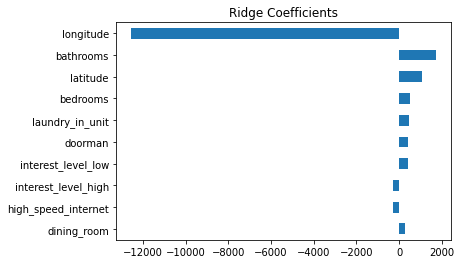

**Note:** Your figure shouldn't be identical to the one above. Your model will have different coefficients since it's been trained on different data. Only the formatting should be the same.

In [66]:
coef = model_r.coef_.transpose()
print(coef.shape)
features = ohe.get_feature_names()
feature_importance = pd.Series(coef, index = features).sort_values(key = abs)
print(feature_importance.shape)
feature_importance

(7,)
(7,)


year_built              194.514578
gross_square_feet       226.227528
borough_4.0           31185.516436
borough_1.0          101892.395161
borough_5.0         -106961.050683
borough_3.0          135723.730733
borough_2.0         -161840.591647
dtype: float64

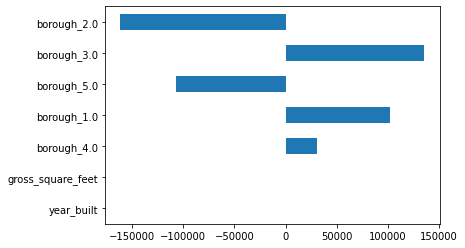

In [69]:
feature_importance.plot(kind = 'barh')